In [1]:
# importing libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import os
import numpy as np

In [15]:
def load_embeddings(path):
    root_dir = path
    x = []
    y = []
    for folder in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, folder)
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            embedding = np.load(file_path).transpose()
            x.append(embedding)
            if folder == 'yes':
                y.append([0, 1])
            else:
                y.append([1, 0])
                
    return x, y

In [16]:
# setting parameter values
path = "../../dataset/optic_disc_embeddings/"
batch_size=32
num_classes = 2

# loading the training dataset
train_x, train_y = load_embeddings(path)

In [17]:
train_x = np.array(train_x)
train_y = np.array(train_y)
print(train_x.shape, train_y.shape)

(174, 1280, 1) (174, 2)


In [3]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(1280, 1)),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [6]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_2 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 2,363,394
Trainable params: 2,363,394
Non-trainable params: 0
_________________________________________________________________


In [20]:
# sets the optimizer, loss function and evaluation metrics
model2.compile(optimizer='adam', 
               loss='binary_crossentropy', 
               metrics=['accuracy',
                        keras.metrics.Precision(name='precision'),
                        keras.metrics.Recall(name='recall')])

# initiates training of the model (only dense layers are changed)
history2 = model2.fit(
    train_x,
    train_y,
    epochs=10,
    batch_size=128,
    validation_split=0.2
)

Epoch 1/10
2/2 [==============================] - 2s 470ms/step - loss: 0.0402 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - val_loss: 0.0825 - val_accuracy: 0.9714 - val_precision: 0.9714 - val_recall: 0.9714
Epoch 2/10
2/2 [==============================] - 0s 85ms/step - loss: 0.0098 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4112 - val_accuracy: 0.9143 - val_precision: 0.9143 - val_recall: 0.9143
Epoch 3/10
2/2 [==============================] - 0s 71ms/step - loss: 0.0015 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.7902 - val_accuracy: 0.8571 - val_precision: 0.8571 - val_recall: 0.8571
Epoch 4/10
2/2 [==============================] - 0s 71ms/step - loss: 0.0248 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - val_loss: 0.5576 - val_accuracy: 0.9143 - val_precision: 0.9143 - val_recall: 0.9143
Epoch 5/10
2/2 [==============================] - 0s 87ms/step - loss: 0.0038 - accuracy: 1.0000 - precision: 1.000

In [21]:
# saves model history to a pickle file
import pickle
with open("optic_disc_detection.pkl", "wb") as f:
    pickle.dump(history2.history,f)

model2.save_weights("optic_disc_detection.h5")

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

model2.load_weights("optic_disc_detection.h5")

In [5]:
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.models import Model

base_model = EfficientNetV2S(weights='imagenet')
layer_name = "avg_pool"
model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)

def preprocess_image(path):
    img = image.load_img(path, target_size=(384, 384))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

1/1 [==============================] - 0s 134ms/step


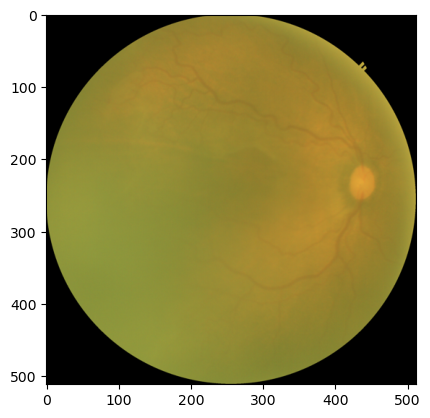

Prediction: optic disc present (100.00%)

1/1 [==============================] - 0s 26ms/step


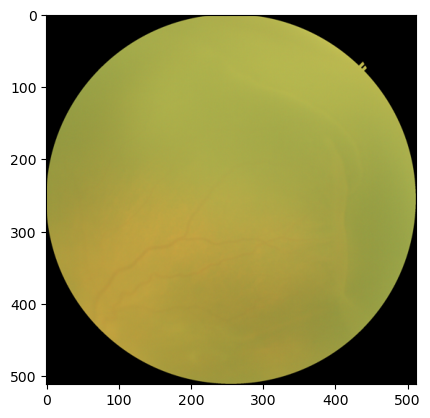

Prediction: no optic disc (99.99%)

1/1 [==============================] - 0s 28ms/step


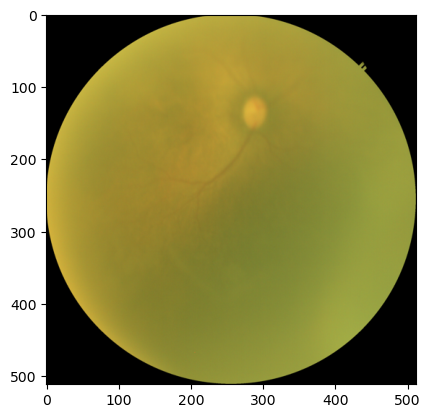

Prediction: optic disc present (100.00%)

1/1 [==============================] - 0s 28ms/step


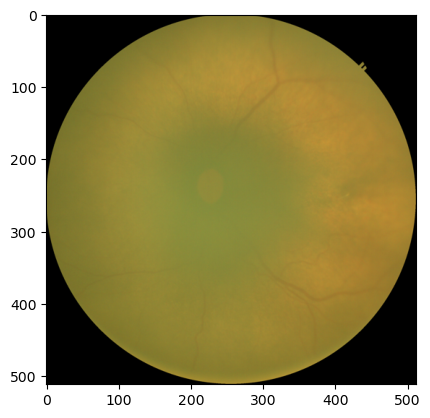

Prediction: optic disc present (100.00%)

1/1 [==============================] - 0s 30ms/step


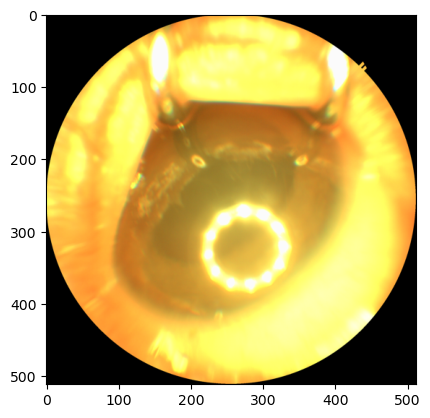

Prediction: no optic disc (100.00%)



In [6]:
image_names = os.listdir("C:/Users/ayush/OneDrive/Documents/Capstone/dataset/data/1/")

num_examples = 5

for i in range(num_examples):
    image_name = np.random.choice(image_names)
    img_path = f"C:/Users/ayush/OneDrive/Documents/Capstone/dataset/data/1/{image_name}"

    labels = ['no optic disc', 'optic disc present']
    x = preprocess_image(img_path)
    embedding = model.predict(x)
    predictions = model2.predict(embedding)
    prediction = np.argmax(predictions[0])
    plt.imshow(Image.open(img_path))
    plt.show()
    print(f"Prediction: {labels[prediction]} ({100 * predictions[0][prediction]:.2f}%)\n")

In [6]:
import shutil

DIR = "../../dataset/NK_TEAM_IMAGES_BACK_UP_REDUCED/"
EMB = "../../dataset/NK_TEAM_IMAGES_embeddings/"
OUT = "../../dataset/temporal_images/"

if not os.path.exists(OUT):
    os.mkdir(OUT)

count = 0
for patient in os.listdir(DIR):
    if not os.path.exists(f"{EMB}{patient}"):
        os.mkdir(f"{EMB}{patient}")
    for dir in os.listdir(f"{DIR}{patient}/"):
        if not os.path.exists(f"{EMB}{patient}/{dir}/"):
            os.mkdir(f"{EMB}{patient}/{dir}/")
        for file_name in os.listdir(f"{DIR}{patient}/{dir}"):
            img_id = file_name.split('.png')[0]
            img_path = f"{DIR}{patient}/{dir}/{file_name}"
            emb_path = f"{EMB}{patient}/{dir}/{img_id}.npy"
            embedding = np.load(emb_path)
            
            predictions = model2.predict(embedding)
            prediction = np.argmax(predictions[0])
            if prediction == 0:
                shutil.copy(f"{DIR}{patient}/{dir}/{file_name}", f"{OUT}{file_name}")
    count += 1
    print(f"{count} patients processed")

1/1 [==============================] - 0s 26ms/step
1 patients processed
1/1 [==============================] - 0s 24ms/step
2 patients processed
1/1 [==============================] - 0s 27ms/step
3 patients processed
1/1 [==============================] - 0s 23ms/step
4 patients processed
1/1 [==============================] - 0s 49ms/step
5 patients processed
1/1 [==============================] - 0s 31ms/step
6 patients processed
1/1 [==============================] - 0s 38ms/step
7 patients processed
1/1 [==============================] - 0s 27ms/step
8 patients processed
1/1 [==============================] - 0s 25ms/step
9 patients processed
1/1 [==============================] - 0s 23ms/step
10 patients processed
1/1 [==============================] - 0s 23ms/step
11 patients processed
1/1 [==============================] - 0s 25ms/step
12 patients processed
1/1 [==============================] - 0s 23ms/step
13 patients processed
1/1 [==============================] - 0s 23ms/